In [1]:
from tqdm import tqdm
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import string
from textblob import TextBlob
import preprocessor as p
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from empath import Empath


In [2]:
# df = pd.read_csv('datasets/verified_features_3k.csv')
df = pd.read_csv('datasets/unverified_features_6k.csv')

In [3]:
# dfs = pd.read_csv('users/verified_features.csv')

In [4]:
# dfs

In [5]:
p.set_options(p.OPT.URL, p.OPT.EMOJI, p.OPT.MENTION, p.OPT.SMILEY, p.OPT.NUMBER)

In [6]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1754641,NYT Business,441.0,786607.0,14628.0,207256.0,0.0,3.0,4.0,4.0,"Financial, tech, media and other business news...",The morning after the President’s rally in Mis...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
1,24733117,Jeffrey Levin,0.0,610302.0,5754.0,611789.0,5.0,36.0,20.0,15.0,"Marketing Programs Manager, social media, huma...","""None of this is normal"": read the full transc...",25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
2,3863605355,History Lovers Club,0.0,547308.0,5048.0,254351.0,0.0,6.0,96.0,0.0,Rare historical photos. All copyrights belong...,President Barack Obama and Pope Francis meet f...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR South Africa,864.0,500713.0,357.0,36650.0,0.0,0.0,7.0,5.0,Diverse. Authentic. Bold.,Lady Gaga shows off huge engagement ring at th...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,Brotips,58.0,464301.0,1503.0,88299.0,0.0,0.0,9.0,4.0,DEALS FOR BROS... Curated products from @brobi...,Nascar Owners Threaten To Fire Drivers Who Pro...,9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [29]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697 entries, 0 to 5699
Data columns (total 19 columns):
uid                5697 non-null object
name               5697 non-null object
friends_count      5697 non-null float64
followers_count    5697 non-null float64
listed_count       5697 non-null float64
statuses_count     5697 non-null float64
pff                5697 non-null float64
pfr                5697 non-null float64
gcf                5697 non-null float64
gcr                5697 non-null float64
description        5697 non-null object
tweets             5697 non-null object
total_fake         5697 non-null float64
total_real         5697 non-null float64
net_trust          5697 non-null float64
total_news         5697 non-null float64
fake_prob          5697 non-null float64
net_trust_norm     5697 non-null float64
fake               5697 non-null float64
dtypes: float64(15), object(4)
memory usage: 890.2+ KB


In [30]:
des = list(df['description'])

In [31]:
# Happy Emoticons
emoticons_happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
emoticons_sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

emoticons = emoticons_happy.union(emoticons_sad)

In [32]:
emoji_pattern = re.compile("["
         u"\U0001F600-\U0001F64F"  # emoticons
         u"\U0001F300-\U0001F5FF"  # symbols & pictographs
         u"\U0001F680-\U0001F6FF"  # transport & map symbols
         u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
         u"\U00002702-\U000027B0"
         u"\U000024C2-\U0001F251"
         "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))

def clean_tweets(tweet):
    word_tokens = word_tokenize(tweet)
    
    tweet = re.sub(r':', '', tweet)
    tweet = re.sub(r'‚Ä¶', '', tweet)
    tweet = re.sub(r'[^\x00-\x7F]+',' ', tweet)
    tweet = emoji_pattern.sub(r'', tweet)
    
    filtered_tweet = []
    
    for w in word_tokens:
        #check tokens against stop words , emoticons and punctuations
        if w not in stop_words and w not in emoticons and w not in string.punctuation:
            filtered_tweet.append(w)
    
    tweet = ' '.join(filtered_tweet).lower()
    text = ''.join([i if ord(i) < 128 else ' ' for i in tweet])
    
    return " ".join(text.split())

In [33]:
clean_desc = []

for d in des:
    d = str(d)
    d = d.replace("\'s", " ")
    d = d.replace("`", " ")
    d = d.replace("\'", " ")
    d = d.replace("#", "").replace("_", " ")
    d = p.clean(d)
    d = clean_tweets(d)
    clean_desc.append(d)

In [34]:
print('Before: ',des[0])
print()
print('After: ', clean_desc[0])

Before:  financial tech media business news the new york times

After:  financial tech media business news new york times


In [35]:
df['description'] = clean_desc

In [36]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1754641,NYT Business,441.0,786607.0,14628.0,207256.0,0.0,3.0,4.0,4.0,financial tech media business news new york times,The morning after the President’s rally in Mis...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
1,24733117,Jeffrey Levin,0.0,610302.0,5754.0,611789.0,5.0,36.0,20.0,15.0,marketing programs manager social media human ...,"""None of this is normal"": read the full transc...",25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
2,3863605355,History Lovers Club,0.0,547308.0,5048.0,254351.0,0.0,6.0,96.0,0.0,rare historical photos copyrights belong respe...,President Barack Obama and Pope Francis meet f...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR South Africa,864.0,500713.0,357.0,36650.0,0.0,0.0,7.0,5.0,diverse authentic bold,Lady Gaga shows off huge engagement ring at th...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,Brotips,58.0,464301.0,1503.0,88299.0,0.0,0.0,9.0,4.0,deals bros ... curated products make life succ...,Nascar Owners Threaten To Fire Drivers Who Pro...,9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [37]:
tweets = list(df['tweets'])

In [38]:
clean_tweet = []

for tweet in tweets:
    tw = tweet.split('^')
    clean_tw = []

    for d in tw:
        d = str(d)
        d = d.replace("\'s", " ")
        d = d.replace("`", "");
        d = d.replace("\"", "")
        d = d.replace("-", " ")
        d = d.replace("#", "").replace("_", " ")
        d = p.clean(d)
        d = clean_tweets(d)
        clean_tw.append(d)
#         print(clean_tw)
    clean_tweet.append("^".join(clean_tw))

In [39]:
print('Before: ',tweets[0].split("^")[2])
print()
print('After: ', clean_tweet[0].split("^")[2])

Before:  Administration Is Seeking $700 Billion for Wall Street Bailout http://tinyurl.com/3f8vpv

After:  administration is seeking 700 billion wall street bailout


In [40]:
df['tweets'] = clean_tweet

In [41]:
# df.head()

In [42]:
df.to_csv("datasets/unverified_features_clean_6k.csv", index = False)

In [43]:
# df = pd.read_csv('users/verified_features_clean.csv')

In [44]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,description,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake
0,1754641,NYT Business,441.0,786607.0,14628.0,207256.0,0.0,3.0,4.0,4.0,financial tech media business news new york times,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0
1,24733117,Jeffrey Levin,0.0,610302.0,5754.0,611789.0,5.0,36.0,20.0,15.0,marketing programs manager social media human ...,none normal read full transcript sen. jeff fla...,25.0,51.0,26.0,76.0,0.328947,0.342105,0.0
2,3863605355,History Lovers Club,0.0,547308.0,5048.0,254351.0,0.0,6.0,96.0,0.0,rare historical photos copyrights belong respe...,president barack obama pope francis meet first...,96.0,6.0,-90.0,102.0,0.941176,-0.882353,1.0
3,53036660,GLAMOUR South Africa,864.0,500713.0,357.0,36650.0,0.0,0.0,7.0,5.0,diverse authentic bold,lady gaga shows huge engagement ring grammys g...,7.0,5.0,-2.0,12.0,0.583333,-0.166667,1.0
4,270106571,Brotips,58.0,464301.0,1503.0,88299.0,0.0,0.0,9.0,4.0,deals bros ... curated products make life succ...,nascar owners threaten to fire drivers who pro...,9.0,4.0,-5.0,13.0,0.692308,-0.384615,1.0


In [45]:
desc = list(df['description'])

In [46]:
desc_sub = []
desc_polar = []

for d in tqdm(desc):
    d = str(d)
    text = TextBlob(d)
    
    desc_sub.append(text.sentiment.subjectivity)
    desc_polar.append(text.sentiment.polarity)    

100%|██████████| 5697/5697 [00:03<00:00, 1778.89it/s]


In [47]:
df['desc_subjectivity'] = desc_sub 
df['desc_polarity'] = desc_polar

In [48]:
df.head(2)

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,tweets,total_fake,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity
0,1754641,NYT Business,441.0,786607.0,14628.0,207256.0,0.0,3.0,4.0,4.0,...,the morning president rally missouri house com...,4.0,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182
1,24733117,Jeffrey Levin,0.0,610302.0,5754.0,611789.0,5.0,36.0,20.0,15.0,...,none normal read full transcript sen. jeff fla...,25.0,51.0,26.0,76.0,0.328947,0.342105,0.0,0.083333,0.016667


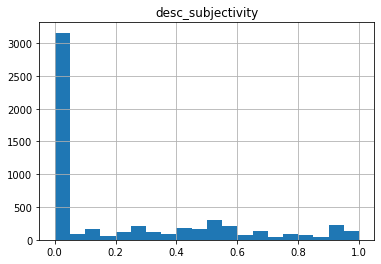

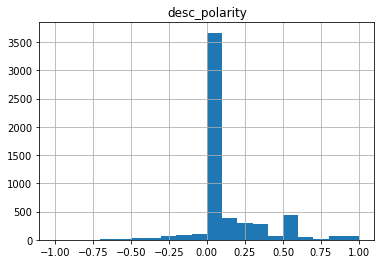

In [49]:
df.hist(column='desc_subjectivity', bins=20)
df.hist(column='desc_polarity', bins=20)

plt.show()

In [50]:
tweets = list(df['tweets'])

tweets_sub = []
tweets_polar = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    sub_arr = []
    polar_arr = []
    
    for d in tw:

        d = str(d)
        text = TextBlob(d)

        sub_arr.append(text.sentiment.subjectivity)
        polar_arr.append(text.sentiment.polarity)    

    sub = sum(sub_arr)/num
    polar = sum(polar_arr)/num    
    
    tweets_sub.append(sub)
    tweets_polar.append(polar)

100%|██████████| 5697/5697 [04:51<00:00, 19.51it/s]  


In [51]:
df['tweets_subjectivity'] = tweets_sub 
df['tweets_polarity'] = tweets_polar

In [52]:
df.head()

,uid,name,friends_count,followers_count,listed_count,statuses_count,pff,pfr,gcf,gcr,...,total_real,net_trust,total_news,fake_prob,net_trust_norm,fake,desc_subjectivity,desc_polarity,tweets_subjectivity,tweets_polarity
0,1754641,NYT Business,441.0,786607.0,14628.0,207256.0,0.0,3.0,4.0,4.0,...,7.0,3.0,11.0,0.363636,0.272727,0.0,0.227273,0.068182,0.145455,-0.049495
1,24733117,Jeffrey Levin,0.0,610302.0,5754.0,611789.0,5.0,36.0,20.0,15.0,...,51.0,26.0,76.0,0.328947,0.342105,0.0,0.083333,0.016667,0.376866,0.034605
2,3863605355,History Lovers Club,0.0,547308.0,5048.0,254351.0,0.0,6.0,96.0,0.0,...,6.0,-90.0,102.0,0.941176,-0.882353,1.0,0.333333,0.100000,0.097059,0.047876
3,53036660,GLAMOUR South Africa,864.0,500713.0,357.0,36650.0,0.0,0.0,7.0,5.0,...,5.0,-2.0,12.0,0.583333,-0.166667,1.0,0.708333,0.416667,0.336111,0.045833
4,270106571,Brotips,58.0,464301.0,1503.0,88299.0,0.0,0.0,9.0,4.0,...,4.0,-5.0,13.0,0.692308,-0.384615,1.0,0.950000,0.750000,0.174709,0.118182


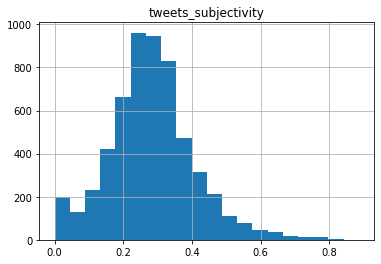

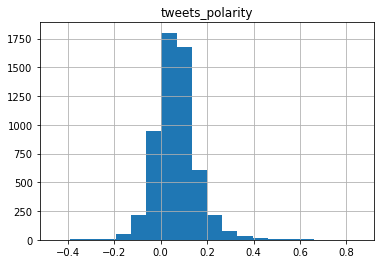

In [53]:
df.hist(column='tweets_subjectivity', bins=20)
df.hist(column='tweets_polarity', bins=20)

plt.show()

In [54]:
lexicon = Empath()

In [55]:
ex = lexicon.analyze(desc[0], normalize=True)

In [56]:
it = list(ex.items())

header = [x for (x,y) in it]

In [57]:
def column_sum(lst):   
    return [sum(i) for i in zip(*lst)] 

In [ ]:
ans = []

for tweet in tqdm(tweets):
    tw = tweet.split("^")
    num = len(tw)
    
    arr = []
    
    for d in tw:

        d = str(d)
        if d == "":
            continue
        it = list(lexicon.analyze(d, normalize=True).items())
        emp = [y for (x,y) in it]
        arr.append(emp)
    
    col_sum = column_sum(arr)
    ans.append([x/num for x in col_sum])

 30%|███       | 1723/5697 [24:55<11:16,  5.87it/s]    

In [ ]:
# tweets[585].split("^")

In [ ]:
len(ans)

In [ ]:
len(ans[0])

In [ ]:
new_head = []

for head in header:
    new_head.append(head + "_empath")

In [ ]:
df_empath = pd.DataFrame(ans, columns = new_head) 

In [ ]:
df_empath

In [ ]:
cols = ['pff', 'pfr', 'gcf', 'gcr', 'description', 'tweets', 'total_fake',
        'total_real', 'net_trust', 'total_news', 'fake_prob', 'net_trust_norm']

df.drop(cols, axis=1, inplace=True)

In [ ]:
df.info()

In [ ]:
df_features = pd.concat(
    [
        df, df_empath
    ], axis=1
)

In [ ]:
df_features.head(10)

In [ ]:
# df_features = pd.read_csv('datasets/verified_features_all_300k.csv')

In [ ]:
df_features = df_features.dropna()
# df_features[df_features['uid'] == 936040869878042624]

In [ ]:
df_features.to_csv('datasets/unverified_features_all_6k.csv', index=False)

In [ ]:
df_features.hist(column='positive_emotion_empath', bins=20)


plt.show()

In [ ]:

# df_features.hist(column='friends_count', bins=20)
# df_features.hist(column='followers_count', bins=20)
# df_features.hist(column='listed_count', bins=30)
# df_features.hist(column='statuses_count', bins=30)

# plt.show()

In [ ]:
df_features.info()